# Table of content

* [Motivation](#motivation)
* [Simulation-based estimation](#simulation-based)
    * [Decision making assumption](#decision-making-assumption)
    * [Data assumption](#data-assumption)
    * [Run experiment](#run-experiment)
* [References](#references)

## Motivation <a class="anchor" id="motivation"></a>

People live in a world where many things are uncertain - i.e., the number of cars on the road at a particular time. As humans, we usually take uncertainty into account when making any decision. In addition, awaring the uncertainty helps people to make better decisions. In this notebook, we want to show how we can make better decisions with uncertainty.

Firstly, we will use **mortgage loan** as an use case to work on. Ultimately, we want to see the benefit of taking some risk; how much the expected profits would be? how much the uplift in terms of market size is?.

## Simulation-based approach <a class="anchor" id="simulation-based"></a>

Before simulating the outcome, we firstly need to make some assumptions about the data and how the decision maker make a decision.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from tqdm import tqdm
from typing import Dict, Tuple, List
from IPython.core.interactiveshell import InteractiveShell
from pandarallel import pandarallel

pandarallel.initialize()
InteractiveShell.ast_node_interactivity = "all"

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
# hyperparameter

SEED = 123

N_USER = 1_000
N_YEAR = 30
INTEREST_RATE = 0.06  # 6% per year
DEFAULT_RATE = 0.005  # 0.5%

### Decision making assumption <a class="anchor" id="decision-making-assumption"></a>

Let's say all customers **are not holding any debt**, and come to the bank intending to get loan with 30 years contract (Mortgage).

This is how the decision logic works:

* The customer has monthly salary $S$, and the maximum holding debt per customer is 40% of their salary [[4]](https://www.sansiri.com/content/view/%E0%B8%84%E0%B8%B3%E0%B9%81%E0%B8%99%E0%B8%B0%E0%B8%99%E0%B8%B3%E0%B8%81%E0%B8%B9%E0%B9%89%E0%B8%9A%E0%B9%89%E0%B8%B2%E0%B8%99-%E0%B9%80%E0%B8%87%E0%B8%B4%E0%B8%99%E0%B9%80%E0%B8%94%E0%B8%B7%E0%B8%AD%E0%B8%99-20,000-%E0%B8%A1%E0%B8%99%E0%B8%B8%E0%B8%A9%E0%B8%A2%E0%B9%8C%E0%B9%80%E0%B8%87%E0%B8%B4%E0%B8%99%E0%B9%80%E0%B8%94%E0%B8%B7%E0%B8%AD%E0%B8%99%E0%B8%81%E0%B8%B9%E0%B9%89%E0%B9%80%E0%B8%87%E0%B8%B4%E0%B8%99%E0%B8%8B%E0%B8%B7%E0%B9%89%E0%B8%AD%E0%B8%9A%E0%B9%89%E0%B8%B2%E0%B8%99%E0%B9%84%E0%B8%94%E0%B9%89%E0%B8%81%E0%B8%B5%E0%B9%88%E0%B8%A5%E0%B9%89%E0%B8%B2%E0%B8%99/th).

* As we assume the customer are not holding any debt, the installment will be $I = S * 0.4$.

* If installment is less than minimum mortgage payment, deny the loan.

**Mortgage payment per month** [[9]](https://www.bankrate.com/mortgages/mortgage-calculator/)

$$
M = P\frac{r(1+r)^n}{(1+r)^n - 1}
$$

Where, 

$M$ is the monthly payment

$P$ is the mortgage amount

$r$ is the monthly interest rate

$n$ is the number of payment

</br>

**Maximum mortgage amount**

$$
P = M\frac{(1+r)^n - 1}{r(1+r)^n}
$$

where, $M = I = S * 0.4$

In [3]:
def calculate_mortgage_payment_per_month(p: float, r: float, n: int = 360) -> float:
    """
    Calcuate the mortgage payment per month
    
    Args:
        p: mortgage amount
        r: monthly interest rate
        n: number of payment (default 360)
        
    Returns:
        monthly per month
    """
    
    numerator = r * (1 + r) ** n
    denominator = (1 + r) ** n - 1
    res = p * numerator / denominator
    return res


def calculate_maximum_mortgage_amount(s: float, r: float, n: int = 360) -> float:
    """
    Calculate the maximum mortgage allowance
    
    Args:
        s: salary/income
        r: monthly interest rate
        n: number of payment (default 360)
        
    Returns:
        the maximum mortgage allowance
    """
    
    numerator = (1 + r) ** n - 1
    denominator = r * (1 + r) ** n
    m = s * 0.4
    res = m * numerator / denominator
    return res

### Data assumption <a class="anchor" id="data-assumption"></a>

#### Customer income

In this variable, we assume the distribution of the income is come from one of the postively skewed distribution family - e.g., log-normal, gamma, skewed-normal distribution. In addition, we assume the mean of the income is around 20,000 THB based on [[8]](https://www.wongnai.com/articles/cost-of-living?ref=ct) blog. 

In [4]:
def generate_income(n: int, seed: int = SEED, method: str = "lognorm") -> np.ndarray:
    dist = None
    if method == "lognorm":
        dist = stats.lognorm(0.7)
    elif method == "gamma":
        dist = stats.gamma(1)
    elif method == "skewnorm":
        dist = stats.skewnorm(10)
    else:
        raise NotImplementedError(f"{method} method is not implemented.")
    
    rvs = dist.rvs(size=n, random_state=seed)
    
    # scale up the random samples
    res = rvs * 20_000 / np.mean(rvs)
    
    return res

In [5]:
# fig, ax = plt.subplots(figsize=(10, 7))

# for dist_name in ["gamma", "skewnorm", "lognorm"]:
#     _ = sns.distplot(generate_income(N_USER, SEED, dist_name), ax=ax, label=dist_name)
# _ = plt.legend()
# _ = plt.xlabel("Income")

In [6]:
# assume the customer's income distribution is the log-normal distribution.
cust_income = generate_income(N_USER, SEED, "lognorm")

# bining the income
income_bin_names = ["<= 8,000", "(8,000 -> 15,000]", "(15,000 -> 30,000]", "(30,000 -> 50,000]", "> 50,000"]
cust_income_bin = pd.cut(cust_income, bins=[-np.inf, 8_000, 15_000, 30_000, 50_000, np.inf], labels=income_bin_names)

/var/folders/sc/ms13ry7x46nd59scs4hqmj2r0000gn/T/ipykernel_58500/4291546690.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  _ = sns.distplot(cust_income, ax=ax[0])


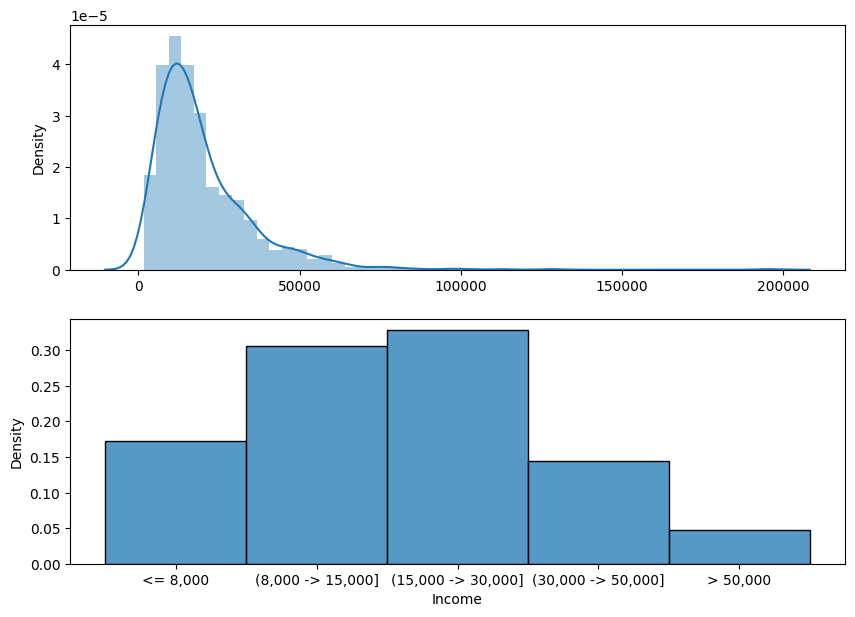

In [7]:
fig, ax = plt.subplots(nrows=2, figsize=(10, 7))
_ = sns.distplot(cust_income, ax=ax[0])
_ = sns.histplot(cust_income_bin, ax=ax[1], stat='density')
_ = plt.xlabel("Income")

#### Interest rate

In [8]:
interest_rate_strategies = [
    [0.06, 0.05, 0.045, 0.042, 0.040],
    [0.06, 0.05, 0.04,  0.03,  0.02],
    [0.1 , 0.09, 0.08,  0.04,  0.035],
    [0.05, 0.05, 0.04,  0.04,  0.03],
    [0.06, 0.06, 0.06,  0.06,  0.06]
]

In [9]:
interest_rates = dict(zip(income_bin_names, interest_rate_strategies[0]))

In [10]:
interest_rates

{'<= 8,000': 0.06,
 '(8,000 -> 15,000]': 0.05,
 '(15,000 -> 30,000]': 0.045,
 '(30,000 -> 50,000]': 0.042,
 '> 50,000': 0.04}

In [11]:
cust_interest_rates = cust_income_bin.map(interest_rates)

#### Default rate

In order to make the assumption simpler, we assume all the income buckets use the same default rate.

In [12]:
cust_default = stats.bernoulli(DEFAULT_RATE).rvs(size=N_USER, random_state=SEED)

#### Construct the customer data

In [13]:
cust_df = pd.DataFrame({
    "income": cust_income,
    "income_bin": cust_income_bin,
    "default": cust_default,
    "interest_rate": cust_interest_rates,
})

cust_df.head()

,income,income_bin,default,interest_rate
0,7536.551066,"<= 8,000",0,0.060
1,32389.940430,"(30,000 -> 50,000]",0,0.042
2,19644.374848,"(15,000 -> 30,000]",0,0.045
3,5614.203813,"<= 8,000",0,0.060
4,10747.636877,"(8,000 -> 15,000]",0,0.050


#### Expected profit 

We assume that customer will take the maximum mortgage allowance. So, profit is the different between total payment and maximum mortgage allowance.

In [14]:
def get_expected_profit(mortgage_amount: pd.Series, interest_rate: pd.Series) -> pd.DataFrame:
    tmp = pd.DataFrame({
        "mortgage_amount": mortgage_amount, 
        "interest_rate": interest_rate
    })
    
    tmp["monthly_payment"] = tmp.parallel_apply(
        lambda row: calculate_mortgage_payment_per_month(row["mortgage_amount"], row["interest_rate"] / 12)
    , axis=1)
    
    tmp["total_to_pay"] = tmp["monthly_payment"] * N_YEAR * 12
    
    tmp["expected_profit"] = tmp["total_to_pay"] - tmp["mortgage_amount"]
    
    return tmp.drop(["mortgage_amount", "interest_rate"], axis=1)

In [15]:
cust_df

,income,income_bin,default,interest_rate
0,7536.551066,"<= 8,000",0,0.060
1,32389.940430,"(30,000 -> 50,000]",0,0.042
2,19644.374848,"(15,000 -> 30,000]",0,0.045
3,5614.203813,"<= 8,000",0,0.060
4,10747.636877,"(8,000 -> 15,000]",0,0.050
...,...,...,...,...
995,25129.445185,"(15,000 -> 30,000]",0,0.045
996,34077.900692,"(30,000 -> 50,000]",0,0.042
997,8526.484729,"(8,000 -> 15,000]",0,0.050
998,22396.186632,"(15,000 -> 30,000]",0,0.045


In [16]:
cust_df["mortgage_amount"] = cust_df.parallel_apply(
    lambda row: calculate_maximum_mortgage_amount(row["income"], row["interest_rate"] / 12)
, axis=1)

# cust_df["total_to_pay"] = cust_df.parallel_apply(
#     lambda row: calculate_mortgage_payment_per_month(row["mortgage_amount"], row["cust_interest_rate"] / 12) * N_YEAR * 12
# , axis=1)

# cust_df["expected_profit"] = cust_df["total_to_pay"] - cust_df["mortgage_amount"]

In [17]:
get_expected_profit(cust_df["mortgage_amount"], cust_df["interest_rate"])

,monthly_payment,total_to_pay,expected_profit
0,3014.620427,1.085263e+06,5.824499e+05
1,12955.976172,4.664151e+06,2.014761e+06
2,7857.749939,2.828790e+06,1.277975e+06
3,2245.681525,8.084453e+05,4.338845e+05
4,4299.054751,1.547660e+06,7.468248e+05
...,...,...,...
995,10051.778074,3.618640e+06,1.634810e+06
996,13631.160277,4.907218e+06,2.119757e+06
997,3410.593892,1.227814e+06,5.924829e+05
998,8958.474653,3.225051e+06,1.456996e+06


In [18]:
cust_df.head()

,income,income_bin,default,interest_rate,mortgage_amount
0,7536.551066,"<= 8,000",0,0.060,5.028134e+05
1,32389.940430,"(30,000 -> 50,000]",0,0.042,2.649391e+06
2,19644.374848,"(15,000 -> 30,000]",0,0.045,1.550815e+06
3,5614.203813,"<= 8,000",0,0.060,3.745608e+05
4,10747.636877,"(8,000 -> 15,000]",0,0.050,8.008349e+05


In [19]:
# # calculate the maximum mortgage allowance
# cust_max_mortgage_allowance = np.array(list(map(lambda inc: calculate_maximum_mortgage_amount(inc, INTEREST_RATE / 12), cust_income)))

# cust_total_payment = np.array(list(map(lambda p: calculate_mortgage_payment_per_month(p, INTEREST_RATE / 12), cust_max_mortgage_allowance))) * N_YEAR * 12

# expected_profit = cust_total_payment - cust_max_mortgage_allowance

#### Model confidence

We use recall to indicate the model confidence for each class.

In [20]:
model_conf_levels = {
    bin_name: conf for bin_name, conf in zip(income_bin_names, [0.1, 0.5, 0.5, 0.1, 0.5])
}

model_conf_levels

{'<= 8,000': 0.1,
 '(8,000 -> 15,000]': 0.5,
 '(15,000 -> 30,000]': 0.5,
 '(30,000 -> 50,000]': 0.1,
 '> 50,000': 0.5}

In [21]:
model_conf = cust_income_bin.map(model_conf_levels)

#### Model prediction

In [22]:
def norm_output(xs: np.ndarray) -> np.ndarray:
    """
    Normalize the vector to sum up to 1
    
    Args:
        xs: logits output
        
    Returns:
        normalized output
    """
    
    norm_xs = xs / xs.sum()
    return norm_xs


def calculate_entropy(xs: np.ndarray) -> float:
    """
    Calculate entropy of the prediction.
    
    Args:
        xs: normalized output
        
    Returns:
        the entropy
    """
    
    ent = - (xs * np.log2(xs)).sum()
    return ent

In [23]:
def random_prediction_wrt_entropy(upper_ent: float) -> Tuple[np.ndarray, int]:
    """
    Random model prediction with respect to entropy.
    
    Args:
        upper_ent: upper bound of entropy
        
    Returns:
        model probability and number of sample time.
    """
    
    i = 0
    while True:
        pred = np.random.uniform(size=5)
        norm_pred = norm_output(pred)
        ent = calculate_entropy(norm_pred)
        i += 1
        if ent < upper_ent:
            return norm_pred, i

        
def get_probs_from_target_class(class_idx: int, upper_ent: float) -> np.ndarray:
    probs, _ = random_prediction_wrt_entropy(upper_ent)
    max_idx = probs.argmax()
    probs[max_idx], probs[class_idx] = probs[class_idx], probs[max_idx]  # swap
    return probs

In [24]:
def get_prediction(income_bin: str, model_perf: float):
    true_idx = income_bin_names.index(income_bin)
    if np.random.uniform() <= model_perf:
        probs = get_probs_from_target_class(true_idx, 1.0)
    else:
        probs = get_probs_from_target_class(np.random.choice(range(5)), 1.0)
    return probs

In [25]:
t = pd.DataFrame({
    "income_bin": cust_income_bin, 
    "model_performance": model_conf
})

In [26]:
model_preds = np.stack(t.parallel_apply(
    lambda row: get_prediction(row["income_bin"], row["model_performance"])
, axis=1).values)

#### Construct prediction data

In [27]:
preds = pd.DataFrame(model_preds, columns=income_bin_names)
preds["pred"] = list(map(lambda x: income_bin_names[x], model_preds.argmax(axis=1)))
preds["interest_rate"] = preds["pred"].map(interest_rates)

In [28]:
preds.head()

,"<= 8,000","(8,000 -> 15,000]","(15,000 -> 30,000]","(30,000 -> 50,000]","> 50,000",pred,interest_rate
0,0.085277,0.022343,0.843870,0.040445,0.008064,"(15,000 -> 30,000]",0.045
1,0.026138,0.010897,0.829361,0.119993,0.013612,"(15,000 -> 30,000]",0.045
2,0.097622,0.063510,0.832073,0.001629,0.005165,"(15,000 -> 30,000]",0.045
3,0.084842,0.104683,0.803304,0.001027,0.006145,"(15,000 -> 30,000]",0.045
4,0.018286,0.747642,0.006206,0.220118,0.007747,"(8,000 -> 15,000]",0.050


In [29]:
from sklearn.metrics import classification_report, confusion_matrix

In [30]:
pd.DataFrame(
    confusion_matrix(cust_df["income_bin"], preds["pred"], labels=income_bin_names),
    index=income_bin_names,
    columns=income_bin_names
)

,"<= 8,000","(8,000 -> 15,000]","(15,000 -> 30,000]","(30,000 -> 50,000]","> 50,000"
"<= 8,000",45,20,34,39,35
"(8,000 -> 15,000]",26,174,32,33,41
"(15,000 -> 30,000]",18,25,204,30,51
"(30,000 -> 50,000]",25,26,26,39,29
"> 50,000",5,6,3,7,27


Assuminig a borrower with a high income will be considered a lower risk to the lender, and will be offered a lower interest rate. On the other hand, a borrower with a lower income will be considered a higher risk, and will be offered a higher interest rate.

Moreover, the loan amount for borrowers will be based on their true income.

In [31]:
diff = get_expected_profit(cust_df["mortgage_amount"], cust_df["interest_rate"]) - \
get_expected_profit(cust_df["mortgage_amount"], preds["interest_rate"])

In [32]:
(diff >= 0).sum() / diff.shape[0]

monthly_payment    0.833
total_to_pay       0.833
expected_profit    0.833
dtype: float64

In [33]:
profit = diff[diff["expected_profit"] >= 0]["expected_profit"].sum()
opportunity_loss = diff[diff["expected_profit"] < 0]["expected_profit"].sum()

In [34]:
profit, opportunity_loss, profit / opportunity_loss

(49364062.140345454, -95179642.62040126, -0.5186409696579857)

In [35]:
# print(classification_report(cust_df["cust_income_bin"], preds["pred"], labels=income_bin_names))

### Run experiment <a class="anchor" id="run-experiment"></a>

In [36]:
def calculate_expected_outcome(cust_df: pd.DataFrame, preds: pd.DataFrame) -> Dict:
    default_cust = cust_df[cust_df["default"] == 1]
    non_default_cust = cust_df[cust_df["default"] == 0]
    
    default_loss = default_cust["mortgage_amount"].sum()
    
    actual_expected_profit = get_expected_profit(
        non_default_cust["mortgage_amount"], 
        non_default_cust["interest_rate"]
    )
    
    model_expected_profit = get_expected_profit(
        cust_df["mortgage_amount"], 
        preds["interest_rate"]
    )
    
    diff = actual_expected_profit - model_expected_profit
    
    profit = diff[diff["expected_profit"] >= 0]["expected_profit"].sum()
    opportunity_loss = - diff[diff["expected_profit"] < 0]["expected_profit"].sum()

    profit_to_opportunity_loss = profit / opportunity_loss
    
    positive_cust_ratio = ((diff >= 0).sum() / diff.shape[0]).iloc[0]
    
    return dict(
        default_loss=default_loss,
        profit=profit,
        opportunity_loss=opportunity_loss,
        profit_to_opportunity_loss=profit_to_opportunity_loss,
        actual_expected_profit=actual_expected_profit["expected_profit"].sum(),
        model_expected_profit=model_expected_profit["expected_profit"].sum(),
        positive_cust_ratio=positive_cust_ratio
    )
    

def run_simulation(interest_rates: List[float], seed: int) -> Tuple[Dict, pd.DataFrame, pd.DataFrame]:
    
    # generate customer info
    cust_income = generate_income(N_USER, seed, "lognorm")
    cust_income_bin = pd.cut(cust_income, bins=[-np.inf, 8_000, 15_000, 30_000, 50_000, np.inf], labels=income_bin_names)
    cust_income_conf = cust_income_bin.map(model_conf_levels).astype(float)
    cust_default = stats.bernoulli(DEFAULT_RATE).rvs(size=N_USER, random_state=seed)
    cust_interest_rates = cust_income_bin.map(interest_rates)
    
    cust_df = pd.DataFrame({
        "income": cust_income,
        "income_bin": cust_income_bin,
        "default": cust_default,
        "interest_rate": cust_interest_rates,
    })
    
    cust_df["mortgage_amount"] = cust_df.parallel_apply(
        lambda row: calculate_maximum_mortgage_amount(row["income"], row["interest_rate"] / 12)
    , axis=1)
    
    # generate model output
    model_conf = cust_income_bin.map(model_conf_levels)
    
    t = pd.DataFrame({
        "income_bin": cust_income_bin, 
        "model_performance": model_conf
    })
    
    model_preds = np.stack(t.parallel_apply(
        lambda row: get_prediction(row["income_bin"], row["model_performance"])
    , axis=1).values)
    
    preds = pd.DataFrame(model_preds, columns=income_bin_names)
    preds["pred"] = list(map(lambda x: income_bin_names[x], model_preds.argmax(axis=1)))
    preds["interest_rate"] = preds["pred"].map(interest_rates)
    
    outcome = calculate_expected_outcome(cust_df, preds)
    
    return outcome, cust_df, preds

In [37]:
tmp = pd.DataFrame()

for idx, interest_rates_map in enumerate(interest_rate_strategies):
    interest_rates = dict(zip(income_bin_names, interest_rates_map))

    res = []

    for i in tqdm(range(20)):
        outcome, _, _ = run_simulation(interest_rates, i)
        res.append(outcome)
    
    t = pd.DataFrame(res)
    t["interest_rates_idx"] = idx
    
    tmp = tmp.append(t)

tmp = tmp.reset_index(drop=True)

100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [01:28<00:00,  4.43s/it]
/var/folders/sc/ms13ry7x46nd59scs4hqmj2r0000gn/T/ipykernel_58500/955691081.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(t)
100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [01:29<00:00,  4.46s/it]
/var/folders/sc/ms13ry7x46nd59scs4hqmj2r0000gn/T/ipykernel_58500/955691081.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(t)
100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [01:28<00:00,  4.44s/it]
/var/folders/sc/ms13ry7x46nd59scs4hqmj2r0000gn/T/ipykernel_58500/955691081.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future

In [38]:
tmp

,default_loss,profit,opportunity_loss,profit_to_opportunity_loss,actual_expected_profit,model_expected_profit,positive_cust_ratio,interest_rates_idx
0,8.500505e+06,4.373879e+07,8.625335e+07,0.507097,1.291229e+09,1.341490e+09,0.827,0
1,8.929555e+06,4.641952e+07,1.048929e+08,0.442542,1.292415e+09,1.357686e+09,0.819,0
2,4.781941e+06,4.815752e+07,7.848464e+07,0.613592,1.295736e+09,1.330843e+09,0.829,0
3,3.957563e+06,4.408131e+07,9.263310e+07,0.475870,1.294448e+09,1.346367e+09,0.810,0
4,1.174306e+06,4.662380e+07,7.982662e+07,0.584063,1.298658e+09,1.332876e+09,0.818,0
...,...,...,...,...,...,...,...,...
75,9.067633e+06,6.750489e+07,8.995550e+07,0.750425,1.202363e+09,1.230848e+09,0.867,3
76,1.187579e+07,6.472520e+07,8.808441e+07,0.734809,1.199062e+09,1.229997e+09,0.880,3
77,8.555141e+06,7.136859e+07,8.598118e+07,0.830049,1.205096e+09,1.226347e+09,0.873,3
78,4.863464e+06,6.865726e+07,8.345632e+07,0.822673,1.199108e+09,1.217765e+09,0.881,3


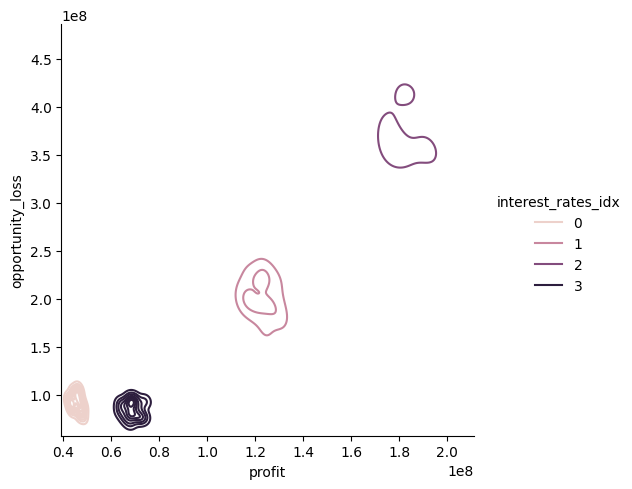

In [39]:
sns.displot(data=tmp, x="profit", y="opportunity_loss", hue="interest_rates_idx", kind="kde")

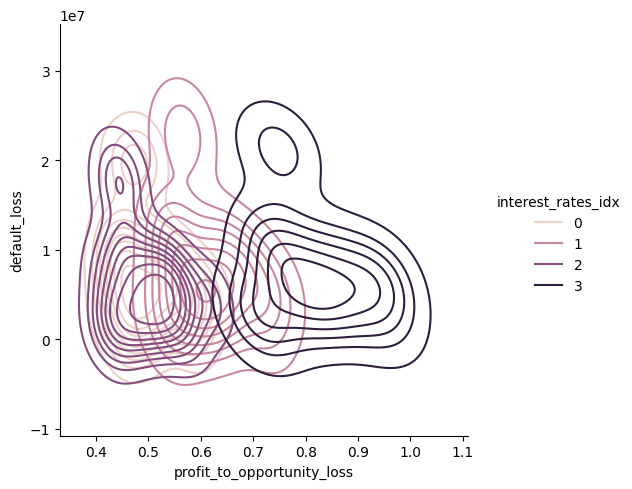

In [40]:
_ = sns.displot(data=tmp, x="profit_to_opportunity_loss", y="default_loss", hue="interest_rates_idx", kind='kde')

## References <a class="anchor" id="references"></a>

1. [Risk-Based Customer Segmentation within Banking](https://medium.com/ibm-data-ai/risk-based-customer-segmentation-within-banking-6109b1104f20)
2. [A Gentle Introduction to Data Science for Credit Risk Modeling](https://mlopshowto.com/an-intro-to-data-science-for-credit-risk-modelling-57935805a911)
3. [Proportion Of Loan Balances To Loan Amounts Is Too High](https://www.sensibledollar.com/proportion-of-loan-balances-to-loan-amounts-is-too-high/)
4. [เงินเดือน 20,000 มนุษย์เงินเดือนกู้เงินซื้อบ้านได้กี่ล้าน
](https://www.sansiri.com/content/view/%E0%B8%84%E0%B8%B3%E0%B9%81%E0%B8%99%E0%B8%B0%E0%B8%99%E0%B8%B3%E0%B8%81%E0%B8%B9%E0%B9%89%E0%B8%9A%E0%B9%89%E0%B8%B2%E0%B8%99-%E0%B9%80%E0%B8%87%E0%B8%B4%E0%B8%99%E0%B9%80%E0%B8%94%E0%B8%B7%E0%B8%AD%E0%B8%99-20,000-%E0%B8%A1%E0%B8%99%E0%B8%B8%E0%B8%A9%E0%B8%A2%E0%B9%8C%E0%B9%80%E0%B8%87%E0%B8%B4%E0%B8%99%E0%B9%80%E0%B8%94%E0%B8%B7%E0%B8%AD%E0%B8%99%E0%B8%81%E0%B8%B9%E0%B9%89%E0%B9%80%E0%B8%87%E0%B8%B4%E0%B8%99%E0%B8%8B%E0%B8%B7%E0%B9%89%E0%B8%AD%E0%B8%9A%E0%B9%89%E0%B8%B2%E0%B8%99%E0%B9%84%E0%B8%94%E0%B9%89%E0%B8%81%E0%B8%B5%E0%B9%88%E0%B8%A5%E0%B9%89%E0%B8%B2%E0%B8%99/th)
5. [Monte Carlo Simulation with Python](https://pbpython.com/monte-carlo.html)
6. [Personal Loan Statistics for 2022](https://www.fool.com/the-ascent/research/personal-loan-statistics/)
7. [Value at risk](https://en.wikipedia.org/wiki/Value_at_risk)
8. [เงินเดือนเท่านี้ ไหวไหม? เทียบค่าครองชีพกับเงินเดือนของแต่ละประเทศ](https://www.wongnai.com/articles/cost-of-living?ref=ct)
9. [Mortgage Calculator](https://www.bankrate.com/mortgages/mortgage-calculator/)
10. [Proxy Income Model - weekly update (06-12-2022)](https://scbcorp.sharepoint.com/:p:/r/teams/DATAXProducts/_layouts/15/Doc.aspx?sourcedoc=%7BE06D5A4E-46B6-4B5A-946F-44E43925C1E4%7D&file=prxy_incm_2022-12-06.pptx&action=edit&mobileredirect=true)
11. [Home Loan Calculator](https://loan-calculators.org/home)